In [16]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from pathlib import Path

data = Path('data')

# Load the json file
with (data / 'franchises.json').open() as f:
	franchises = json.load(f)

# Convert the franchises list to a dataframe
df = pd.DataFrame(franchises)

# Show the dataframe
df = df.sort_values(by=['my_score'], ascending=False)
df

,title,episodes,score,my_score,genres,themes,demographics,studios,licensors,producers
2,"""Oshi no Ko""",11,8.830000,10.000000,"[Supernatural, Drama]","[Reincarnation, Showbiz]",[Seinen],[Doga Kobo],[Sentai Filmworks],"[Shueisha, Kadokawa, CyberAgent]"
54,Tenkuu no Shiro Laputa,1,8.260000,10.000000,"[Fantasy, Adventure, Award Winning, Romance, S...",[],[],[Studio Ghibli],"[Disney Platform Distribution, GKIDS]","[Tokuma Shoten, Streamline Pictures]"
22,Howl no Ugoku Shiro,1,8.660000,10.000000,"[Fantasy, Drama, Adventure, Award Winning, Rom...",[],[],[Studio Ghibli],[Disney Platform Distribution],"[Tokuma Shoten, d-rights]"
53,Tengoku Daimakyou,13,8.230000,10.000000,"[Mystery, Adventure, Sci-Fi]",[Survival],[Seinen],[Production I.G],[],"[Mainichi Broadcasting System, NetEase, Avex P..."
36,Mononoke Hime,1,8.670000,10.000000,"[Fantasy, Award Winning, Adventure, Action]",[],[],[Studio Ghibli],[GKIDS],"[Tokuma Shoten, Nippon Television Network]"
57,Vinland Saga,49,8.757959,9.979592,"[Adventure, Action, Drama]","[Gore, Historical]",[Seinen],"[Wit Studio, MAPPA]",[Sentai Filmworks],"[Twin Engine, Dentsu, Production I.G, Kodansha]"
39,Nichijou:,27,8.420370,9.925926,[Comedy],"[Gag Humor, School]",[Shounen],[Kyoto Animation],"[Funimation, Bandai Entertainment]","[Rakuonsha, Movic, KlockWorx, Kadokawa Shoten,..."
48,Shingeki no Kyojin:,89,8.678876,9.539326,"[Award Winning, Action, Drama, Suspense]","[Gore, Military, Survival]",[Shounen],"[Wit Studio, MAPPA]",[Funimation],"[Mainichi Broadcasting System, Kodansha, Dents..."
42,One Punch Man,24,8.000000,9.500000,"[Action, Comedy]","[Super Power, Parody, Adult Cast]",[Seinen],"[J.C.Staff, Madhouse]",[VIZ Media],"[Bandai Namco Arts, TV Tokyo, Bandai Visual, J..."
18,Fullmetal Alchemist:,115,8.660957,9.113043,"[Fantasy, Drama, Adventure, Award Winning, Act...",[Military],[Shounen],[Bones],"[Funimation, Aniplex of America]","[Mainichi Broadcasting System, Aniplex, Square..."


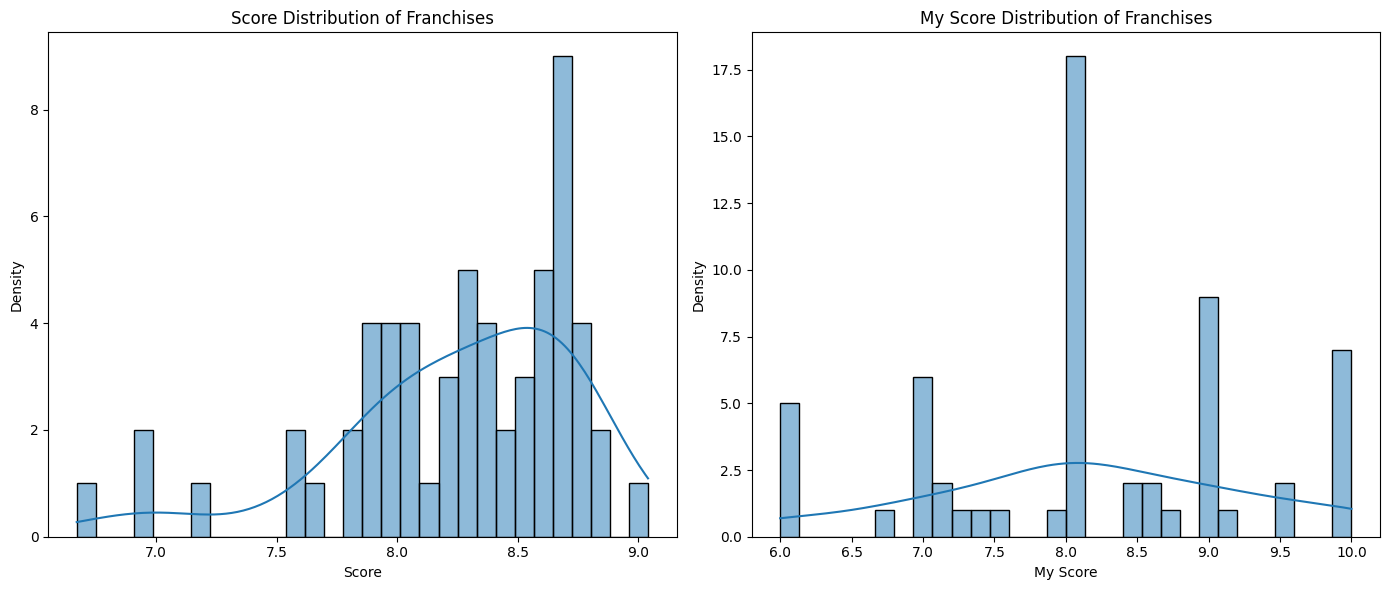

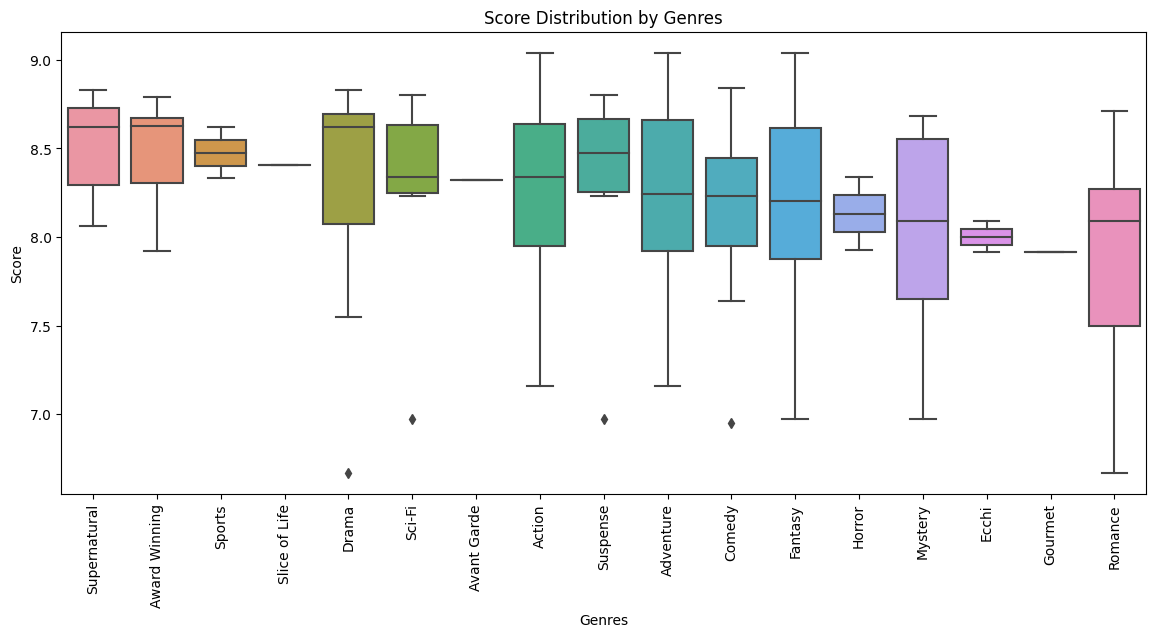

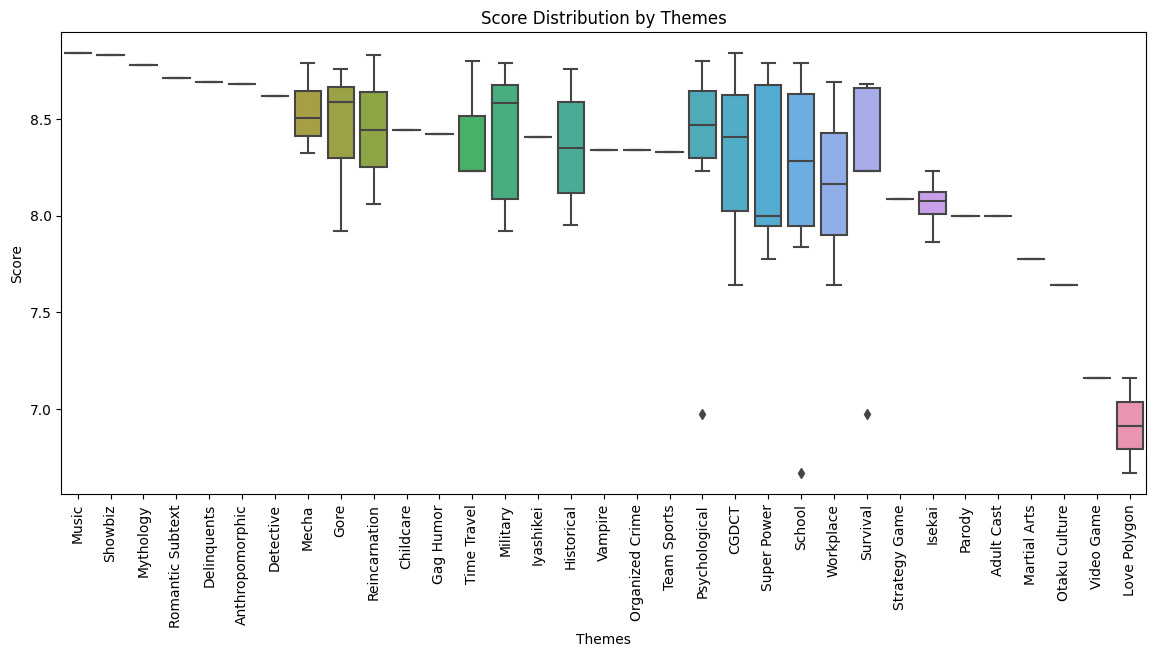

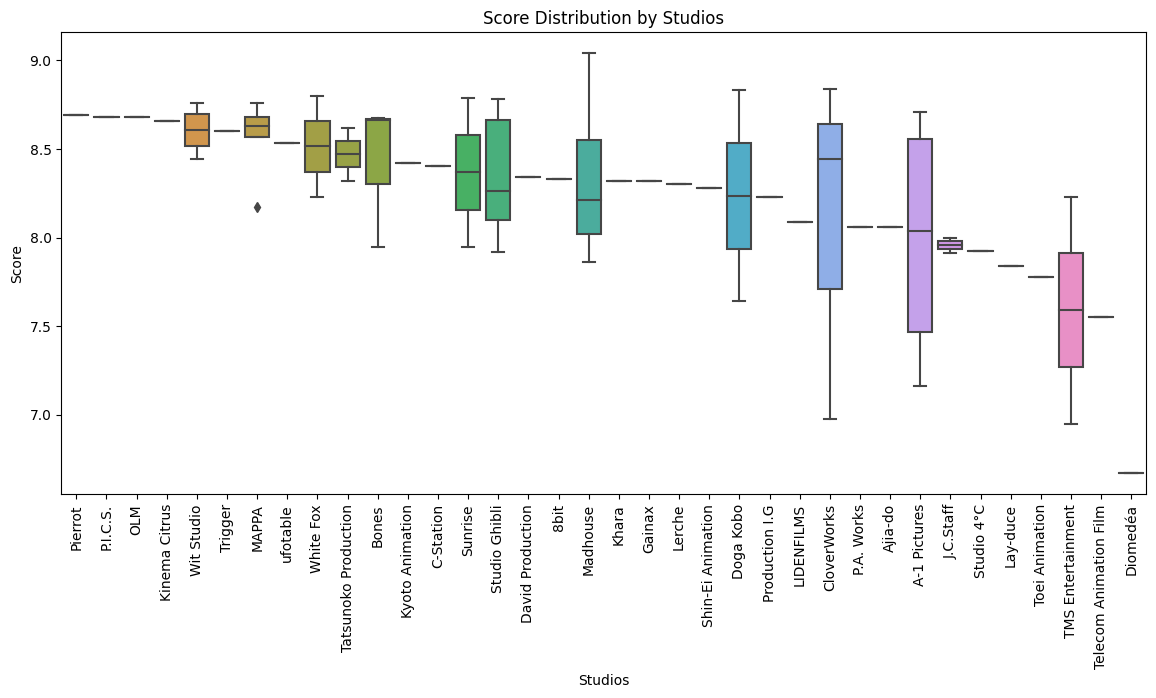

In [17]:
# Remove entries with missing 'score' or 'my_score'
df = df.dropna(subset=['score', 'my_score'])

# Create the figure and subplots for histograms
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Histograms of 'score' and 'my_score'
sns.histplot(df['score'], kde=True, bins=30, ax=axs[0])
axs[0].set_title('Score Distribution of Franchises')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Density')

sns.histplot(df['my_score'], kde=True, bins=30, ax=axs[1])
axs[1].set_title('My Score Distribution of Franchises')
axs[1].set_xlabel('My Score')
axs[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

# Helper function for generating box plots
def box_plot(data, x, y, title, xlabel, ylabel):
    if data[x].notna().any():  # Check if there are any non-null values
        plt.figure(figsize=(14, 6))
        sns.boxplot(x=x, y=y, data=data, order=order)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(rotation=90)
        plt.show()

# Unnest 'genres', 'themes', and 'studios' fields and create box plots
for field in ['genres', 'themes', 'studios']:
    df_unnested = df.explode(field)
    
    # Sort by descending average score
    order = df_unnested.groupby(field)['score'].mean().sort_values(ascending=False).index
    
    box_plot(df_unnested, field, 'score', f'Score Distribution by {field.capitalize()}', field.capitalize(), 'Score')
